# CanESM5 GMD paper Figure 08
## cloud fraction

### history
-  SJH, first look 2019-05-12

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from pprint import pprint
import os
from datetime import datetime
import cartopy.crs as ccrs
import cartopy
import cmocean
from cdo import Cdo
import modules.basic_stats as bst
import modules.plotting_module as pltm
import sqlite3

cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

In [2]:
%store -r fig_08_start 
%store -r fig_08_end

start = fig_08_start
end = fig_08_end

startdate = datetime.strptime(start,'%Y-%m-%d')
enddate   = datetime.strptime(end,'%Y-%m-%d')

In [3]:
#remap the CanESM5 realizations and the ISCCP observation onto a common grid

runCDO = False

if runCDO:
    for root, subdirs, files in os.walk('input_data/CanESM5_cmip_dir/historical/'):
        #narrow down the walk
        if 'Amon' in subdirs:
            subdirs[:] = ['Amon']
        if 'clt' in subdirs:
            subdirs[:] = ['clt']

        for filename in files:
            var, tab, model, expt, rl, grid, dates = filename.split('_')
            if rl.endswith('i1p1f1'):
                CanESM5_clt = filename
                ifile = os.path.join(root, CanESM5_clt)
                ofile = 'input_data/processed_data/clt/remap-woa09_' + CanESM5_clt
                cdo.remapbil('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', input=ifile, output=ofile)

                
    for root, subdirs, files in os.walk('input_data/CanESM2_large_ensemble/'):
        #narrow down the walk
        if 'mon' in subdirs:
            subdirs[:] = ['mon']
        if 'atmos' in subdirs:
            subdirs[:] = ['atmos']
        if 'clt' in subdirs:
            subdirs[:] = ['clt']
        for filename in files:
            if filename.endswith('_195001-202012.nc') and ('historical-' in filename):
                print(filename)
                CanESM2_clt = filename
                ifile = os.path.join(root, CanESM2_clt)
                ofile = 'input_data/processed_data/clt/remap-woa09_' + CanESM2_clt
                cdo.remapbil('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', input=ifile, output=ofile)           
                
                
    ISCCP = 'ISCCP-Basic.HGM.v01r00.GLOBAL.1991.01.2010.12.99.9999.GPC.10KM.CS00.EA1.00_timmean_T63.nc'
    ifile = os.path.join('obs/ISCCP/', ISCCP)
    ofile = 'input_data/processed_data/clt/remap-woa09_' + ISCCP
    cdo.remapbil('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', input=ifile, output=ofile)
    

In [4]:
#ISCCP (units %)

cloud_obs_i = xr.open_dataset('input_data/processed_data/clt/remap-woa09_ISCCP-Basic.HGM.v01r00.GLOBAL.1991.01.2010.12.99.9999.GPC.10KM.CS00.EA1.00_timmean_T63.nc')['cldamt'].squeeze()
cloud_obs = pltm.addCyclicPoint(cloud_obs_i, 'lon')

In [ ]:
#CanESM5 (units %)

CanESM5 = {}
for root, subdirs, files in os.walk('input_data/processed_data/clt/'):
    for filename in files:
        if filename.startswith('remap-woa09_clt_Amon_CanESM5'):
            mapping, var, tab, model, expt, rl, grid, dates = filename.split('_')
            print(rl)
            clt = xr.open_dataset(os.path.join(root,filename))['clt']
            clt_weighted_timemean = pltm.get_weighted_globalmean(clt, 'noleap', start, end)      
 
            CanESM5[rl] = clt_weighted_timemean  


CanESM5_rels = xr.concat([CanESM5[rel] for rel in CanESM5],dim='realization')
CanESM5_relmean_i = CanESM5_rels.mean('realization')
CanESM5_relmean = pltm.addCyclicPoint(CanESM5_relmean_i, 'lon')

In [ ]:
#CanESM2 (units %)

CanESM2 = {}
for root, subdirs, files in os.walk('input_data/processed_data/clt/'):
    for filename in files:
        if filename.startswith('remap-woa09_clt_Amon_CanESM2'):
            mapping, var, tab, model, expt, rl, dates = filename.split('_')
            rl = expt[-2:] + rl
            print(rl)
            clt = xr.open_dataset(os.path.join(root,filename))['clt']
            clt_weighted_timemean = pltm.get_weighted_globalmean(clt, 'noleap', start, end)   

            CanESM2[rl] = clt_weighted_timemean  


CanESM2_rels = xr.concat([CanESM2[rel] for rel in CanESM2],dim='realization')
CanESM2_relmean_i = CanESM2_rels.mean('realization')
CanESM2_relmean = pltm.addCyclicPoint(CanESM2_relmean_i, 'lon')

In [7]:
clt_anomaly = CanESM5_relmean - cloud_obs

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


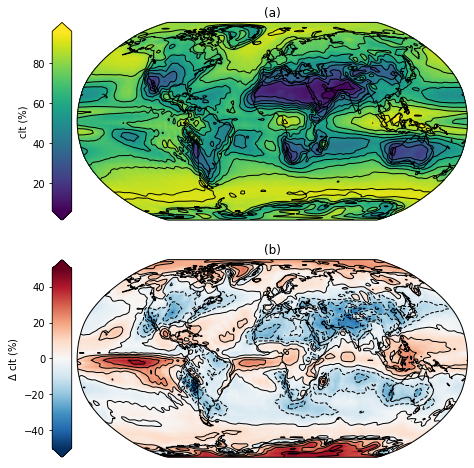

In [8]:
fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot(2,1,1,projection=ccrs.Robinson())
cb_clt = ax1.pcolormesh(CanESM5_relmean.lon, CanESM5_relmean.lat,CanESM5_relmean, cmap=plt.cm.viridis, transform=ccrs.PlateCarree())
pltm.add_cbar('left', fig, ax1, cb_clt, extend='both', label =r'clt (%)')
ax1.contour(CanESM5_relmean.lon, CanESM5_relmean.lat, CanESM5_relmean, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax1.set_title('(a)')


ax2 = plt.subplot(2,1,2,projection=ccrs.Robinson())
cb_cltan = ax2.pcolormesh(clt_anomaly.lon, clt_anomaly.lat,clt_anomaly, cmap=plt.cm.RdBu_r, vmin=-50, vmax=50, transform=ccrs.PlateCarree())
pltm.add_cbar('left', fig, ax2, cb_cltan, extend='both', label =r'$\Delta$ clt (%)')
ax2.contour(clt_anomaly.lon, clt_anomaly.lat, clt_anomaly, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax2.set_title('(b)')

plt.subplots_adjust(wspace=0.05)  

for ax in [ax1,ax2]:
    ax.coastlines()

fig.savefig('plots/fig-08_cloud_fraction.png', bbox_inches='tight')
fig.savefig('plots/fig-08_cloud_fraction.pdf', bbox_inches='tight')

In [ ]:
##### statistics - for global time means
xyzt = 'TTFF'
av_dims = ['time'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections, )
weight  = xr.open_dataset('input_data/obs/woa/woa09_gridarea.nc')['cell_area'] 
calc_skill_score=False

#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names = ['CanESM5','CanESM2']
model_datasets = [CanESM5_relmean_i, CanESM2_relmean_i]
model_fulldatasets = [None,None]

obs_names = ['ISCCP','ISCCP']
obs_datasets = [cloud_obs_i, cloud_obs_i]
obs_fulldatasets = [None, None]

stats_names = ['clt_global_timemean','clt_global_timemean_CanESM2']
varslist = ['clt','clt']


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)

